**PROJECT NAME:**
- DRIBBLING WITH DATA

**GROUP NAME:**
- Data on Dadda

**GROUP MEMBERS:**
- Nik Kota, nkota5
- Yuanxu Zhang, yzhan319
- Joseph Rosales, josephr6
- Solomon Jones, sjones83
- Adam Shaar, ashaar2

***

**Question:** Does maintaining the same starting lineup over several seasons lead to greater team performance in the NBA?

**Hypothesis:** Teams that maintain a consistent starting lineup over multiple seasons are more likely to have better performance due to increased team chemistry and understanding.

In [1]:
# imports

# Data Manipulation and Analysis Libraries
import json
import requests
import numpy as np
import pandas as pd
import http.client
from bs4 import BeautifulSoup
import time

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt


**Our Data**
***
In this section, we are dealing with the collection and preparation of NBA team data for analysis. This process lays the groundwork for subsequent machine learning analysis, focusing on how roster stability (similarity scores) relates to team performance indicators (like win percentages and various on-court statistics).

1. **Data Scraping with NBADataScraper**: The NBADataScraper class is designed to scrape NBA team statistics from a specified season. The class also includes functions for parsing this data and storing it. This structure allows for efficient data collection across multiple NBA seasons.

In [2]:
class NBADataScraper:
    def __init__(self,season):
        self.season = season
        self.team_data = {}
    def get_headers(self):
        return {
            "Accept": "*/*","Accept-Encoding": "gzip, deflate, br","Accept-Language": "en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7","Connection": "keep-alive","Host": "stats.nba.com","Origin": "https://www.nba.com","Referer": "https://www.nba.com/","Sec-Ch-Ua": "\"Chromium\";v=\"118\", \"Google Chrome\";v=\"118\", \"Not=A?Brand\";v=\"99\"","Sec-Ch-Ua-Mobile": "?0","Sec-Ch-Ua-Platform": "\"Windows\"","Sec-Fetch-Dest": "empty","Sec-Fetch-Mode": "cors","Sec-Fetch-Site": "same-site","User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
        }
    def get_team_data(self):
        NBATEAM_URL = "https://stats.nba.com/stats/leaguedashteamstats"
        params = {
            "Conference": "","DateFrom": "","DateTo": "","Division": "","GameScope": "","GameSegment": "","Height": "","ISTRound": "","LastNGames": "0","LeagueID": "00","Location": "","MeasureType": "Base","Month": "0","OpponentTeamID": "0","Outcome": "","PORound": "0",
            "PaceAdjust": "N","PerMode": "PerGame","Period": "0","PlayerExperience": "","PlayerPosition": "","PlusMinus": "N","Rank": "N", "Season": self.season,"SeasonSegment": "","SeasonType": "Regular Season","ShotClockRange": "","StarterBench": "","TeamID": "0","TwoWay": "0","VsConference": "","VsDivision": ""
        }
        response = requests.get(NBATEAM_URL, params=params,headers=self.get_headers())
        return response.json()
    def get_lineUp_data(self):
        NBALINEUP_URL = "https://stats.nba.com/stats/leaguedashlineups"
        params = {
            "Conference": "","DateFrom": "","DateTo": "","Division": "","GameSegment": "","GroupQuantity": "5","ISTRound": "","LastNGames": "0","LeagueID": "00","Location": "","MeasureType": "Base","Month": "0","OpponentTeamID": "0","Outcome": "","PORound": "0",
            "PaceAdjust": "N","PerMode": "PerGame","Period": "0","PlusMinus": "N","Rank": "N","Season": self.season,"SeasonSegment": "","SeasonType": "Regular Season","ShotClockRange": "","TeamID": "0","VsConference": "","VsDivision": ""
        }
        response = requests.get(NBALINEUP_URL, params=params,headers=self.get_headers())
        return response.json()
    def parse_team_data(self):
        data = self.get_team_data()
        headers = data['resultSets'][0]['headers']
        headers[2] = "GamePlayed"
        headers[3] = "Wins"
        headers[4] = "Losses"
        headers[5] = "Win Percentage"
        headers[6] = "Minutes Played"
        rows = data['resultSets'][0]['rowSet']
        for row in rows:
            self.team_data[row[0]] = {
                'TeamOverAllStats':dict(zip(headers, row))
            }
    def parse_lineUp_data(self):
        data = self.get_lineUp_data()
        headers = data['resultSets'][0]['headers']
        headers[5] = "GamePlayed"
        headers[6] = "Wins"
        headers[7] = "Losses"
        headers[8] = "Win Percentage"
        headers[9] = "Minutes Played"
        rows = data['resultSets'][0]['rowSet']
        lineUpDatas = {}
        for row in rows:
            if row[3] not in lineUpDatas:
                lineUpDatas[row[3]] = []
            lineUpDatas[row[3]].append(dict(zip(headers, row)))
        for teamId in list(lineUpDatas.keys()):
            top3_game_played = []
            top3_minutes_played = []
            top3_game_played = sorted(lineUpDatas[teamId], key=lambda x: x['GamePlayed'], reverse=True)[0:3]
            top3_minutes_played = sorted(lineUpDatas[teamId], key=lambda x: x['Minutes Played'], reverse=True)[0:3]
            self.team_data[teamId]['TOP3_GAME_PLAYED'] = top3_game_played
            self.team_data[teamId]['TOP3_MINUTES_PLAYED'] = top3_minutes_played
            self.team_data[teamId]['NUM_LINEUPS'] = len(lineUpDatas[teamId])
    def store_data(self):
        with open(f'team_data_{self.season}.json', 'w') as f:
            json.dump(self.team_data, f, indent=4)

2. **Roster Data Collection**: The script uses a function getTeamRoster to collect roster data for each team across multiple seasons. The apiIDs dictionary maps team IDs to their respective API identifiers. The allRosters dictionary is populated with roster information for each team across different years, using the provided API keys and team IDs.

In [3]:
# Website with documentation about the API used. https://developer.sportradar.com/docs/read/basketball/NBA_v5#push-events
# The above site is needed to get a key to use the API. The free trial has enough requests to get all the information needed for this project
apiKey = '6z943jwue92gscmdu97vde96'
def extractRoster(data):
  Bs_data = BeautifulSoup(data, "xml")
  b_unique = Bs_data.find_all('player')
  roster = []
  for x in b_unique:
    roster.append(x['full_name'])
  return roster
def getTeamRoster(year, id):
  conn = http.client.HTTPSConnection("api.sportradar.us")
  conn.request("GET", "/nba/trial/v5/en/seasons/" + str(year) + "/REG/teams/" + id + "/statistics.xml?api_key=" + apiKey)
  res = conn.getresponse()
  data = res.read()
  return extractRoster(data)

In [4]:
# Warning: this takes about 6 minutes to run
apiIDs = {'1610612737': '583ecb8f-fb46-11e1-82cb-f4ce4684ea4c', # Hawks
          '1610612738': '583eccfa-fb46-11e1-82cb-f4ce4684ea4c', # Celtics
          '1610612751': '583ec9d6-fb46-11e1-82cb-f4ce4684ea4c', # Nets
          '1610612766': '583ec97e-fb46-11e1-82cb-f4ce4684ea4c', # Charlotte
          '1610612741': '583ec5fd-fb46-11e1-82cb-f4ce4684ea4c', # Bulls
          '1610612739': '583ec773-fb46-11e1-82cb-f4ce4684ea4c', # Cavs
          '1610612742': '583ecf50-fb46-11e1-82cb-f4ce4684ea4c', # Mavs
          '1610612743': '583ed102-fb46-11e1-82cb-f4ce4684ea4c', # Nuggets
          '1610612765': '583ec928-fb46-11e1-82cb-f4ce4684ea4c', # Pistons
          '1610612744': '583ec825-fb46-11e1-82cb-f4ce4684ea4c', # Warriors
          '1610612745': '583ecb3a-fb46-11e1-82cb-f4ce4684ea4c', # Rockets
          '1610612754': '583ec7cd-fb46-11e1-82cb-f4ce4684ea4c', # Pacers
          '1610612746': '583ecdfb-fb46-11e1-82cb-f4ce4684ea4c', # Clippers
          '1610612747': '583ecae2-fb46-11e1-82cb-f4ce4684ea4c', #Lakers
          '1610612763': '583eca88-fb46-11e1-82cb-f4ce4684ea4c', #Grizzlies
          '1610612748': '583ec8d4-fb46-11e1-82cb-f4ce4684ea4c', #Heat
          '1610612749': '583ecefd-fb46-11e1-82cb-f4ce4684ea4c', #Bucks
          '1610612750': '583eca2f-fb46-11e1-82cb-f4ce4684ea4c', # Timberwolves
          '1610612740': '583ecc9a-fb46-11e1-82cb-f4ce4684ea4c', #New Orleans
          '1610612752': '583ec70e-fb46-11e1-82cb-f4ce4684ea4c', # Knicks
          '1610612760': '583ecfff-fb46-11e1-82cb-f4ce4684ea4c', #Thunder
          '1610612753': '583ed157-fb46-11e1-82cb-f4ce4684ea4c', # Magic
          '1610612755': '583ec87d-fb46-11e1-82cb-f4ce4684ea4c', #76ers
          '1610612756': '583ecfa8-fb46-11e1-82cb-f4ce4684ea4c', #Suns
          '1610612757': '583ed056-fb46-11e1-82cb-f4ce4684ea4c', #Blazers
          '1610612758': '583ed0ac-fb46-11e1-82cb-f4ce4684ea4c', #Kings
          '1610612759': '583ecd4f-fb46-11e1-82cb-f4ce4684ea4c', #Spurs
          '1610612761': '583ecda6-fb46-11e1-82cb-f4ce4684ea4c', #Raptors
          '1610612762': '583ece50-fb46-11e1-82cb-f4ce4684ea4c', #Jazz
          '1610612764': '583ec8d4-fb46-11e1-82cb-f4ce4684ea4c' #Wizards
          }
allRosters = {}
for key in apiIDs:
  rosters = {}
  for i in range(10):
    year = 2013 + i
    time.sleep(1)
    rosters[year] = getTeamRoster(year, apiIDs[key])
  allRosters[key] = rosters

3. **Combining Seasonal Team Data**: The yearsOfData list is populated with instances of NBADataScraper for consecutive NBA seasons. For each season, team statistics and lineup data are parsed and stored. The all_seasons_data list compiles all these statistics across the seasons.

In [5]:
yearsOfData = []
for i in range(11):
  year = str(2012 + i) + '-' + str(13 + i)
  nba = NBADataScraper(year)
  nba.parse_team_data()
  nba.parse_lineUp_data()
  yearsOfData.append(nba)

In [6]:
all_seasons_data = []
for scraper in yearsOfData:
    for team_id, team_info in scraper.team_data.items():
        team_stats = team_info["TeamOverAllStats"]
        team_stats["Season"] = scraper.season
        all_seasons_data.append(team_stats)

df = pd.DataFrame(all_seasons_data)

4. Calculating Roster Similarity Scores: The script calculates roster similarity scores for each team and season, comparing the rosters of consecutive years. It evaluates how many players are retained each season, providing a measure of roster stability.

In [7]:
similarity_scores = {}
for team_id, seasons in allRosters.items():
    similarity_scores[team_id] = {}
    for year in range(2013, 2023):
        previous_roster = seasons.get(year - 1, [])
        current_roster = seasons[year]
        matching_players = 0
        for player in previous_roster:
            if player in current_roster:
                matching_players += 1
        if len(current_roster) > 0:
            similarity_score = matching_players / len(current_roster)
        else:
            similarity_score = 0
        similarity_scores[team_id][year] = similarity_score


5. Combining Data for Analysis: The final step involves merging the team statistics with the calculated roster similarity scores. This is done in the combined_data list, where each entry contains team statistics and the corresponding similarity score for a particular season. This data is then converted into a data frame for further analysis.

In [8]:
combined_data = []
for year_data in yearsOfData:
    for team_id, team_stats in year_data.team_data.items():
        season_year = int(team_stats['TeamOverAllStats']['Season'][-2:]) + 2000
        season_year += 1 if season_year < 2050 else 0
        similarity_score = similarity_scores.get(str(team_id), {}).get(season_year, 0)
        combined_row = {**team_stats['TeamOverAllStats'], 'Roster_Similarity': similarity_score, 'Season_Year': season_year - 1, 'num_lineups': team_stats['NUM_LINEUPS']}
        combined_data.append(combined_row)
df = pd.DataFrame(combined_data)

In [9]:
all_seasons_data = []
for scraper in yearsOfData:
    for team_id, team_info in scraper.team_data.items():
        team_stats = team_info["TeamOverAllStats"]
        team_stats["Season"] = scraper.season
        all_seasons_data.append(team_stats)
df = pd.DataFrame(all_seasons_data)

**Data Visualization**
***


One of the most important stats in measuring success in the NBA is via Wins and Losses. Although this stat is crucial to success, this visualization aims to explore some other stats and their impact on success so that we can later tune models to understand what stats are most impactful for a teams success.

This first visualization uses the NBADataScraper to look at how multiple players staying in the main lineups for teams relates to how many wins a team gets in a season. Using the functions defined below, this code checks every team, looks at how long a set number of players stayed in a lineup for the team, and checks the longest span of team some players stayed in the lineup and what their winrate looked like at the peak of their time together. The player variable can be adjusted to get different visualizations for a different amount of players in the same lineup, however, for the final report we have chosen to visualize with 3 players, as this was the most informative towards the hypothesis we were trying to prove.

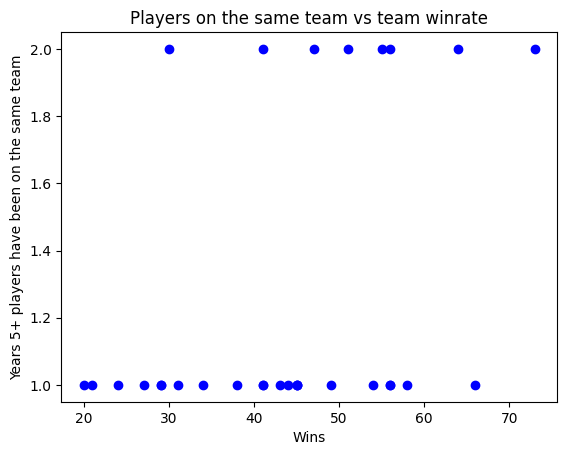

In [10]:
def getLongestLineup(teamID, allData, players):
  max = 0
  consecutiveNum = 0
  wins = 0
  prevLineup = ''
  for x in allData:
    if prevLineup == '':
      prevLineup = x.team_data[teamID]["TOP3_GAME_PLAYED"][0]['GROUP_NAME']
      consecutiveNum += 1
    else:
      if checkPlayers(players, prevLineup, x.team_data[teamID]["TOP3_GAME_PLAYED"][0]['GROUP_NAME']):
        consecutiveNum += 1
      else:
        consecutiveNum = 1
        prevLineup = x.team_data[teamID]["TOP3_GAME_PLAYED"][0]['GROUP_NAME']
    if consecutiveNum > max:
          max = consecutiveNum
          wins = x.team_data[teamID]['TeamOverAllStats']['Wins']
  return max, wins

def checkPlayers(numPlayers, lineupOne, lineupTwo):
  l1 = lineupOne.split(' - ')
  l2 = lineupTwo.split(' - ')
  count = 0
  for name in l1:
    if l2.count(name) > 0:
      count += 1
  if count >= numPlayers:
    return True
  return False

def getTeamIDs(seasonData):
  IDs = []
  for key in seasonData.team_data:
    IDs.append(key)
  return IDs

players = 5
teamIDs = getTeamIDs(yearsOfData[0])
points = []
for team in teamIDs:
  points.append(getLongestLineup(team, yearsOfData, players))


y_coords, x_coords = zip(*points)

plt.scatter(x_coords, y_coords, color='blue', marker='o')

plt.title('Players on the same team vs team winrate')
plt.xlabel('Wins')
plt.ylabel('Years ' + str(players) + '+ players have been on the same team')

plt.show()

This next set of code uses the data retrieved form SportRadars API. For each team throughout the years 2014-2022 it looks at each team and compares all the players listed on the roster between years and calculates a percentrage which represents how much of the roster stayed the same, and how much of the roster was changed between two years. The visualizations allow for all teams to be looked at individually, as well as there being a looped version which creates a graph for each team, however, this is not present in the final because with 30 teams it took up too much space. The code for looping and looking at all 30 teams will still be provided, but not ran. This code gave a lot of insight on how much teams actually change thier roster between seasons, and although didn't confirm the original hypothesis, it demonstrated a lot of patterns and interesting data to look at from team to team.

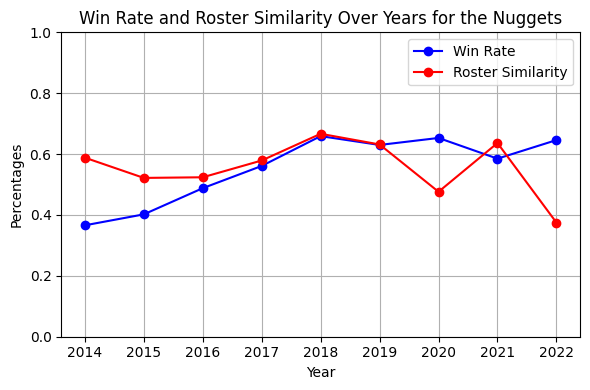

In [12]:
teams = {'Hawks': '1610612737', # Hawks
          'Celtics': '1610612738', # Celtics
          'Nets': '1610612751', # Nets
          'Hornets': '1610612766', # Charlotte
          'Bulls': '1610612741', # Bulls
          'Cavaliers': '1610612739', # Cavs
          'Mavericks': '1610612742', # Mavs
          'Nuggets': '1610612743', # Nuggets
          'Pistons': '1610612765', # Pistons
          'Warriors': '1610612744', # Warriors
          'Rockets': '1610612745', # Rockets
          'Pacers': '1610612754', # Pacers
          'Clippers': '1610612746', # Clippers
          'Lakers': '1610612747', #Lakers
          'Grizzlies': '1610612763', #Grizzlies
          'Heat': '1610612748', #Heat
          'Bucks': '1610612749', #Bucks
          'Timberwolves': '1610612750', # Timberwolves
          'Pelicans': '1610612740', #New Orleans
          'Knicks': '1610612752', # Knicks
          'Thunder': '1610612760', #Thunder
          'Magic': '1610612753', # Magic
          '76ers': '1610612755', #76ers
          'Suns': '1610612756', #Suns
          'Trail Blazers': '1610612757', #Blazers
          'Kings': '1610612758', #Kings
          'Spurs': '1610612759', #Spurs
          'Raptors': '1610612761', #Raptors
          'Jazz': '1610612762', #Jazz
          'Wizards': '1610612764' #Wizards
          }


def getRosterSimilarity(currentRoster, previousRoster):
  total = 0
  matching = 0
  for player in previousRoster:
    total += 1
    if currentRoster.count(player) > 0:
      matching += 1
  return (matching / total)

def getAllRosterSimilarities():
  similarities = {}
  for key in allRosters:
    temp = []
    for x in range(9):
      year = 2014 + x
      temp.append(getRosterSimilarity(allRosters[key][year], allRosters[key][year - 1]))
    similarities[key] = temp
  return similarities

def getWinRates():
  winRates = {}
  for x in yearsOfData:
    year = x.season[:4]
    wins = {}
    for key in x.team_data:
      wins[key] = x.team_data[key]['TeamOverAllStats']['Win Percentage']
    winRates[year] = wins
  return winRates

def getDataPoints(teamID):
  data = []
  similarities = getAllRosterSimilarities()
  winRates = getWinRates()

  for i in range(9):
    year = 2014 + i
    rate = winRates[str(year)][int(teamID)]
    percent = similarities[str(teamID)][i]
    data.append((rate, percent))
  return data

def buildGraph(team):
  dataPoints = getDataPoints(teams[team])


  # Years from 2014 to 2022
  years = list(range(2014, 2023))

  # Extract win rates and roster similarities
  win_rates = [d[0] for d in dataPoints]
  roster_similarities = [d[1] for d in dataPoints]

  # Plotting
  plt.figure(figsize=(6, 4))
  plt.plot(years, win_rates, marker='o', linestyle='-', color='blue', label='Win Rate')
  plt.plot(years, roster_similarities, marker='o', linestyle='-', color='red', label='Roster Similarity')
  plt.ylim(0, 1.0)
  plt.title('Win Rate and Roster Similarity Over Years for the ' + team)
  plt.xlabel('Year')
  plt.ylabel('Percentages')
  plt.legend()
  plt.grid(True)
  plt.xticks(years)  # Set x-axis ticks to display only the years provided
  plt.tight_layout()

  # Display the plot
  plt.show()

buildGraph('Nuggets')

# This is the code for looping over all teams and showing the graphs for them. Uncomment if you'd like to see all graphs for each team(30)
# for key in teams:
  # buildGraph(key)

In [ ]:
# Check the average similarity between all teams over all seasons to get a general idea of how much teams change each season.
similarities = getAllRosterSimilarities()
count = 0
total = 0
for teamID in similarities:
  for x in similarities[teamID]:
    count += 1
    total += x
avg = total / count
print('Average roster similarity: ' + str(avg))

Average roster similarity: 0.47613309636699963


Here we have used a lineplot to show the number of unique lineups and their respective winrates over 10 years. According to our hypothesis, where the winrates are lower, the # of unique lineups should be higher, and where the winrates are higher, the # of unique lineups should be lower. There exists a weak correlation between this visualization (as well as others generated) and our hypothesis. Since this is just a start, and there are several other factors to take into account when discussing the "success" of a team, this is a great start.

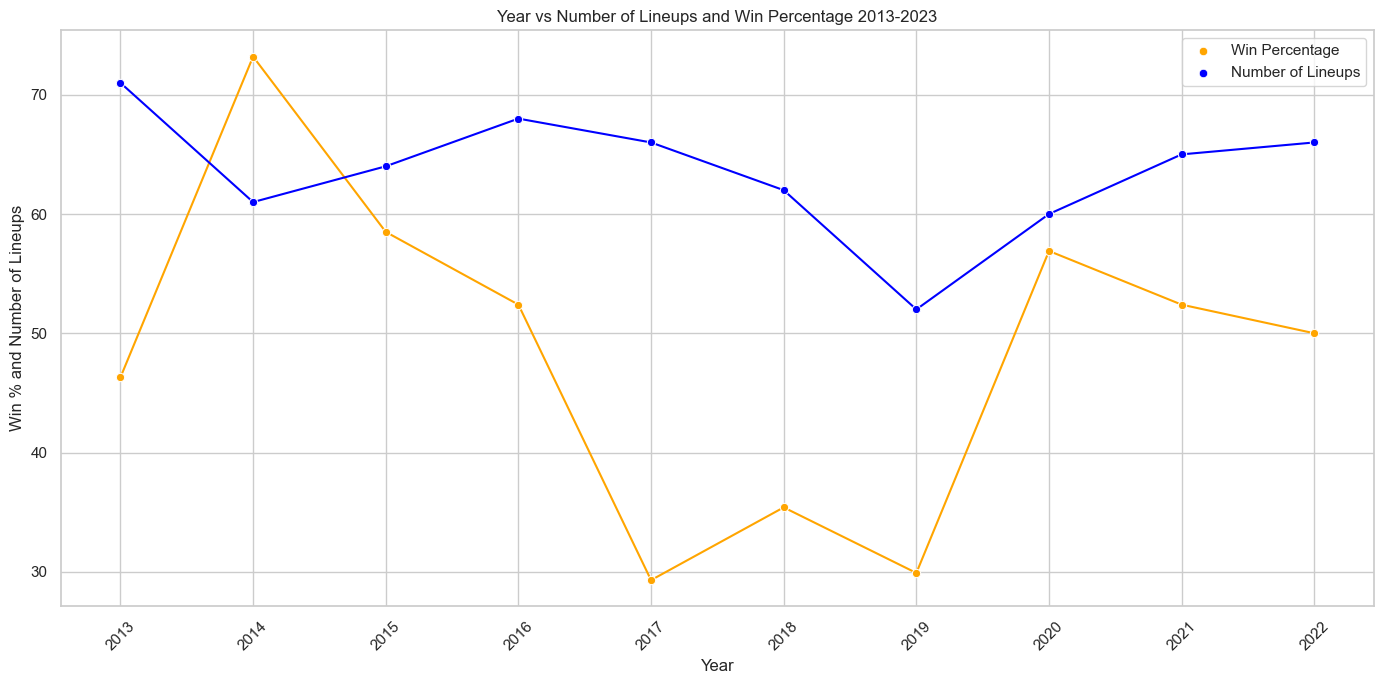

In [ ]:
accumulated_df = pd.DataFrame()
for i in range(0, 10):
    titling = str(2013+i)+"-"+str(14+i)
    with open(f"team_data_{titling}.json", 'r') as f:
        team_data1 = json.load(f)
    team_id1 = []
    team_stats1 = []
    num_lineups1 = []
    for key, value in team_data1.items():
        team_id1.append(key)
        team_stats1.append(value['TeamOverAllStats'])
        num_lineups1.append(value['NUM_LINEUPS'])
    team_stats_df1 = pd.DataFrame(team_stats1)
    team_id_df1 = pd.DataFrame({'TeamID': team_id1})
    num_lineups_df1 = pd.DataFrame({'NumLineups': num_lineups1})
    year1 = pd.DataFrame({'Year': [str(2013 + i)] * len(team_id1)})
    result_df1 = pd.concat([team_id_df1, team_stats_df1, num_lineups_df1, year1], axis=1)
    result_df1['Win Percentage'] = result_df1['Win Percentage'] * 100
    accumulated_df = pd.concat([accumulated_df, result_df1], ignore_index=True)
years_order = sorted(accumulated_df['Year'].unique())
accumulated_df['Year'] = pd.Categorical(accumulated_df['Year'], categories=years_order, ordered=True)
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
scatter_plot_win_pct = sns.scatterplot(
    data=accumulated_df[accumulated_df['TeamID'] == '1610612737'],
    x='Year', y='Win Percentage', color='orange', marker='o')
scatter_plot_num_lineups = sns.scatterplot(
    data=accumulated_df[accumulated_df['TeamID'] == '1610612737'],
    x='Year', y='NumLineups', color='blue', marker='o')
sns.lineplot(
    data=accumulated_df[accumulated_df['TeamID'] == '1610612737'],
    x='Year', y='Win Percentage', color='orange', marker='o', ax=scatter_plot_win_pct)
sns.lineplot(
    data=accumulated_df[accumulated_df['TeamID'] == '1610612737'],
    x='Year', y='NumLineups', color='blue', marker='o', ax=scatter_plot_num_lineups)
plt.title('Year vs Number of Lineups and Win Percentage 2013-2023')
plt.xlabel('Year')
plt.ylabel('Win % and Number of Lineups')
plt.legend(['Win Percentage', 'Number of Lineups'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**ML Analysis**
***

**Linear Regression with Single Feature**
- predict NBA teams' win percentages using the number of lineups ('num_lineups') a team has used in a season

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['num_lineups']], df['Win Percentage'], test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
print(f"R-squared value: {r2_score(y_test, model.predict(X_test))}")
print(f"Coefficients: {model.coef_[0]}")

R-squared value: -0.026516503020757254
Coefficients: -0.002860465765175261


- poor model performance
- relationship is not reliable.

**Random Forest for Win Percentage Prediction**
- predict the win percentage based on various team statistics

In [ ]:
features = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'Roster_Similarity', 'num_lineups']
X = df[features]
y = df['Win Percentage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error for  Win Percentage Prediction: {mse}")
print(f"R-squared for  Win Percentage Prediction: {r2}")
importances = model.feature_importances_
importance_series = pd.Series(importances, index=features).sort_values(ascending=False)
print("Feature Importances for Win Percentage Prediction:\n", importance_series)

Mean Squared Error for  Win Percentage Prediction: 0.010009830749999999
R-squared for  Win Percentage Prediction: 0.5921095868940048
Feature Importances for Win Percentage Prediction:
 FG3_PCT              0.205333
FG_PCT               0.194529
BLKA                 0.117516
TOV                  0.058476
REB                  0.047291
BLK                  0.043902
PFD                  0.042782
STL                  0.029693
FGA                  0.028613
DREB                 0.027545
FTM                  0.025522
PF                   0.024131
num_lineups          0.019606
OREB                 0.017634
FTA                  0.016349
Roster_Similarity    0.015821
AST                  0.015469
FT_PCT               0.015370
FG3A                 0.015231
FGM                  0.014003
PTS                  0.013806
FG3M                 0.011376
dtype: float64


- R-squared: 0.5983 (moderately strong model performance, explaining about 59.83% of the variance in the win percentage).
- Feature Importances: 'FG3_PCT' and 'FG_PCT' are the most influential features, followed by 'BLKA', indicating the significant impact of these statistics on a team's win percentage.

**Random Forest for Roster Similarity Prediction**
- predicts 'Roster_Similarity' using a random forest regressor based on various team performance statistics

In [ ]:
features = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'num_lineups']
X = df[features]
y = df['Roster_Similarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error for Roster_Similarity Prediction: {mse}")
print(f"R-squared for Roster_Similarity Prediction: {r2}")
importances = model.feature_importances_
importance_series = pd.Series(importances, index=features).sort_values(ascending=False)
print("Feature Importances for Roster_Similarity Prediction:\n", importance_series)

Mean Squared Error for Roster_Similarity Prediction: 0.036772904802893254
R-squared for Roster_Similarity Prediction: 0.26296294504127005
Feature Importances for Roster_Similarity Prediction:
 PTS            0.115688
FG3A           0.095039
FG_PCT         0.071962
FG3M           0.069098
DREB           0.067520
FTA            0.055577
PFD            0.048276
AST            0.045500
PF             0.045288
FGA            0.042401
FG3_PCT        0.042036
FTM            0.038544
num_lineups    0.036217
REB            0.034204
BLK            0.033940
STL            0.029982
FGM            0.029810
FT_PCT         0.025703
OREB           0.025241
TOV            0.024967
BLKA           0.023006
dtype: float64


- Feature Importances: 'PTS' (points) and 'FG3A' (three-point attempts) are the most influential in predicting roster similarity, suggesting a correlation between these metrics and the stability of a team's roster.

**Results**
***
In conclusion, the analysis suggests that while roster stability does have a role in a team's success, it is not the most influential factor. On-court performance, particularly efficiency in scoring and defensive measures, plays a more prominent role in determining a team's win percentage. Roster stability contributes to a team's success but is part of a broader set of factors that influence overall team performance.